# Deep Learning: Movie Review Sentiment Analysis

For this project, we will be creating a deep learning model that is capable of classifying movie reviews by sentiment (positive vs negative reviews).

We will be using the IMDB movie reviews dataset from Kaggle (cited at end) for this task.

# More About the Data

The IMDB movie reviews dataset is a collection of 50,000 movie reviews, either positive or negative reviews, collected from the IMDB (Internet Movie Database) website.  The reviews are "highly polar" i.e. either very positive or very negative, which is ideal for our training purposes.

# Mount Google Drive

Mount our Google Drive to be able to access our data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Our Dataset

Load the movie reviews from Google Drive and inspect them.

Our data is very simple in structure - only two columns, one feature ("review") which is the text of a movie review, and a label ("sentiment") labeling that review as either a "positive" review or a "negative" review.

In [ ]:
import pandas as pd

# load the data from Drive
file_path = "/content/drive/My Drive/imdb-reviews/IMDB Dataset.csv"
df = pd.read_csv(file_path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Data Preprocessing: Inspect Dataset For Null Values

Below, we check the DataFrame info.  We have exactly 50,000 reviews.

As we can see, there are no null values in either column, so no need to clean null values out of the dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Data Preprocessing: Inspect Dataset For Duplicates

Using the `describe` method of our DataFrame, we can see that our `review` column appears to have fewer "unique" reviews (~49.5k) than the total number of reviews (50k), implying that not every review is unique and that we may have some duplicates.  We should validate this further.

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


# Data Preprocessing: Inspect Duplicate Reviews

To validate that we have duplicates, we extract any duplicate reviews from the dataset and inspect them.  Sure enough, we do clearly have some duplicate reviews.

In [ ]:
# get an inspect duplicate reviews
duplicate_reviews = df[df.duplicated(subset=['review'], keep=False)]
duplicate_reviews = duplicate_reviews.sort_values(by="review")
duplicate_reviews.head(5)

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


# Data Preprocessing: Remove Duplicate Reviews

Below, we remove our duplicates from the dataset.  Duplicates are important to remove with deep learning models because multiple occurrences of the same values can cause memorization/overfitting by the model.

In [ ]:
# remove duplicate reviews
df = df.drop_duplicates(subset=['review'], keep='first')
df.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,No one expects the Star Trek movies to be high...,positive
freq,1,24884


# Data Preprocessing: Encoding True Labels

We also need to encode our labels to binary, as they are currently strings ("positive"/"negative") and thus unusable by the model.

In [ ]:
import numpy as np

# encode Sentiment label
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
y = np.array(df['sentiment'])

# EDA: Inspect Class Balance

We ideally want a balanced dataset for our model, to achieve optimal results.  Plotting the distribution of positive vs negative reviews below, we can see that the reviews are almost perfectly balanced between positive and negative reviews.

As such, our dataset requires no further balancing.

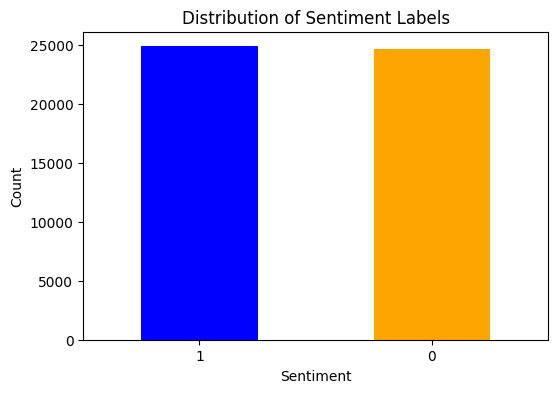

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="bar", figsize=(6,4), color=['blue', 'orange'])

plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Labels")
plt.xticks(rotation=0)

plt.show()


# EDA: Review Word Count Histogram

It's also useful to get a sense of how long (in words) our reviews are for data processing purposes.  As we can see, the vast majority of our reviews are under 600 words in length.

We will use this (600) as our maximum review length parameter later, when creating our word embeddings.

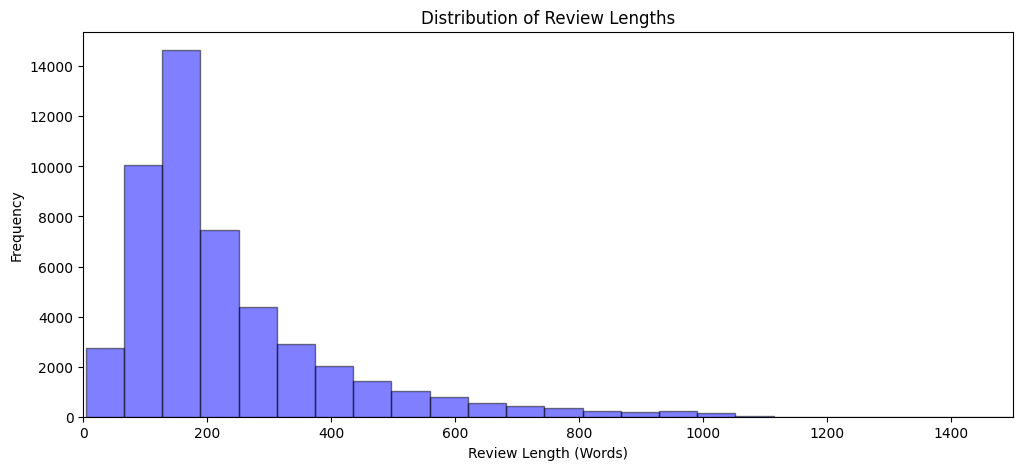

In [ ]:
# histogram of review lengths
import numpy as np

word_count = [len(review.split()) for review in df['review']]

plt.figure(figsize=(12,5))
plt.hist(word_count, bins=40, color='blue', alpha=0.5, edgecolor='black')
plt.xlabel("Review Length (Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.xlim(0,1500)
plt.show()

# Data Preprocessing: Tokenization

For our model to use these reviews, they must be broken down into tokens.  

Tokens are basically sub-sections of a long text string.  They are often the words in a sentence, but can also be punctuation, individual characters, etc. depending on the situation.

In order to tokenize our data, we first fit the tokenizer on our review dataset.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

# use top N number of words
vocab_size = 10000
# max review length
max_length = 600

# tokenize reviews
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['review'])

# Data Preprocessing: Tokenization Pt. 2

Next, we tokenize the data and convert those tokens into integers that represent each token.

These integers are really indices taken from a mapping created by the tokenizer, where lower integers represent tokens that appear more frequently in the dataset and higher integers/indices represent tokens that appear less frequently in the dataset.

We also pad our tokenized sequences to be of a consistent length, which allows for more efficient ingestion by our model.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# encode review text to numerical sequences for model
X = tokenizer.texts_to_sequences(df['review'])
# pad encoded reviews to consistent length
X = pad_sequences(X, maxlen=max_length, padding='post', truncating='post')

# Train/Test Split

We split our data into train and test datasets (80/20) for training and validation purposes.

In [ ]:
from sklearn.model_selection import train_test_split

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Architecture 1: LSTM Model

Here, we define a function return an LSTM (long short-term memory) model.  LSTMs are RNN (recurrent neural network) models that are intended to process sequential data, in our case - movie reviews.  

LSTMs are chosen over RNNs for this kind of task because LSTMs are superior at remembering information long-term, by using specific gates designed to retain this information.

Our model architecture is as follows:
- An embedding layer to convert our tokenized data into vectors that capture word meaning
- A bidirectional LSTM layer that processes our reviews both forwards and backwards for better understanding of context
- A dropout layer to prevent overfitting
- Another bidirectional LSTM layer, but smaller
- Another dropout layer
- A Dense layer for high-level feature extraction
- A final output layer that gives us our predictions in probability form

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

embedding_dim = 128

def get_lstm_model(lr):

  model = Sequential([
      # convert words into vectors
      Embedding(vocab_size, embedding_dim, input_length=max_length),
      # bidirectional LSTM layer processes words backwards and forwards to predict sentiment
      Bidirectional(LSTM(128, return_sequences=True)),
      # dropout to prevent overfitting
      Dropout(0.2),
      # another LSTM layer
      Bidirectional(LSTM(64)),
      # dropout to prevent overfitting
      Dropout(0.2),
      # feature extraction layer
      Dense(64, activation='relu'),
      # output layer, outputs a probability
      Dense(1, activation='sigmoid')
  ])

  model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
      metrics=['accuracy']
      )

  return model

# Model Architecture 1: Fit Model

Fit our model with the default learning rate.

In [ ]:
model = get_lstm_model(lr=0.001)

model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test, y_test),
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - accuracy: 0.6995 - loss: 0.5579 - val_accuracy: 0.6460 - val_loss: 0.6418
Epoch 2/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.6902 - loss: 0.5962 - val_accuracy: 0.8061 - val_loss: 0.4546
Epoch 3/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 86s 119ms/step - accuracy: 0.8536 - loss: 0.3507 - val_accuracy: 0.8862 - val_loss: 0.2857
Epoch 4/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 78s 113ms/step - accuracy: 0.9256 - loss: 0.2012 - val_accuracy: 0.8986 - val_loss: 0.2491
Epoch 5/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 69s 112ms/step - accuracy: 0.9473 - loss: 0.1522 - val_accuracy: 0.9020 - val_loss: 0.2526


# Model Architecture 1: Evaluation

Evaluate our results by checking the accuracy of our model's predictions.  

Accuracy is a suitable metric in this case because our classes are nearly perfectly balanced.

As we can see, our model performs very well for our first iteration, achieving 90% accuracy with a high and relatively balanced F1 score for each class.

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
# get classification report for first model
print(classification_report(y_test, y_pred))

310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      4939
           1       0.88      0.93      0.91      4978

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



# Model Architecture 2: Hybrid GRU/RNN Model

We try a different architecture next, a hybrid model including both GRU and CNN layers.  The idea is to use the CNN layer for feature extraction and the GRU layer for sequence understanding.  

GRUs are sometimes chosen as alternatives to LSTMs, as GRUs use fewer gates and can sometimes produce similar results while being faster and computationally cheaper.

The architecture is as follows:
- An embedding layer to convert our tokenized data into vectors that capture word meaning
- A convolutional layer to extract local/short word patterns
- A bidirectional GRU layer that processes our reviews both forwards and backwards for better understanding of context
- A dropout layer to prevent overfitting
- Another bidirectional GRU layer, but smaller
- Another dropout layer
- A Dense layer for high-level feature extraction
- A final output layer that gives us our predictions in probability form

In [ ]:
from tensorflow.keras.layers import Embedding, Conv1D, GRU

hybrid_model = Sequential([
    # Embedding layer
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    # 1D Conv layer for feature extraction
    Conv1D(128, kernel_size=5, activation='relu'),
    # Bidirectional GRU layer
    Bidirectional(GRU(64, return_sequences=True)),
    # Dropout to prevent overfitting
    Dropout(0.3),
    # Another GRU layer
    Bidirectional(GRU(32)),
    # More dropout
    Dropout(0.3),
    # Feature extraction layer
    Dense(64, activation='relu'),
    # Output layer, outputs probability
    Dense(1, activation='sigmoid')
])

# Compile the model
hybrid_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Model Architecture 2: Fit Model

Fit our hybrid model with the training data.

In [ ]:
hybrid_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 61s 90ms/step - accuracy: 0.6784 - loss: 0.5658 - val_accuracy: 0.8340 - val_loss: 0.4186
Epoch 2/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.9076 - loss: 0.2474 - val_accuracy: 0.9041 - val_loss: 0.2426
Epoch 3/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.9533 - loss: 0.1359 - val_accuracy: 0.9041 - val_loss: 0.2525
Epoch 4/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 78s 103ms/step - accuracy: 0.9766 - loss: 0.0742 - val_accuracy: 0.8823 - val_loss: 0.3616
Epoch 5/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 78s 97ms/step - accuracy: 0.9855 - loss: 0.0486 - val_accuracy: 0.8932 - val_loss: 0.3931


# Model Architecture 2: Evaluation

In evaluating our second model architecture, we see that the results are very similar to our first model, although just barely worse in both accuracy and F1 score, with an accuracy of 89%.  This model did take slightly less (5%) time to train, though, which is potentially worth noting.

In [ ]:
hybrid_y_pred = hybrid_model.predict(X_test)
hybrid_y_pred = (hybrid_y_pred > 0.5).astype(int)
# get classification report for second model
print(classification_report(y_test, hybrid_y_pred))

310/310 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      4939
           1       0.93      0.86      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.90      0.89      0.89      9917
weighted avg       0.90      0.89      0.89      9917



# Model Architecture Comparison

A visual comparison between both model accuracy scores.  Certainly a minor difference, but overall higher performance from the LSTM model.

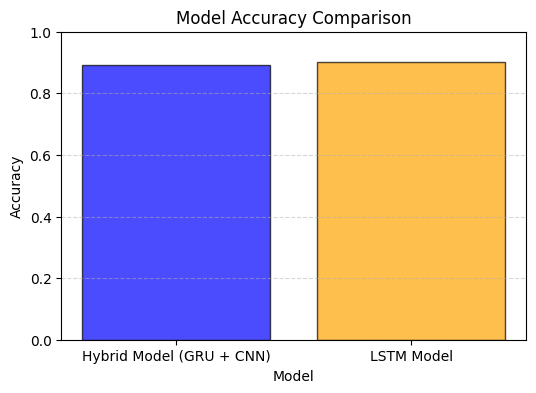

In [ ]:
hybrid_acc = classification_report(y_test, hybrid_y_pred, output_dict=True)['accuracy']
lstm_acc = classification_report(y_test, y_pred, output_dict=True)['accuracy']

models = ['Hybrid Model (GRU + CNN)', 'LSTM Model']
accuracies = [hybrid_acc, lstm_acc]

# plot model comparison re: accuracy
plt.figure(figsize=(6,4))
plt.bar(models, accuracies, color=['blue', 'orange'], alpha=0.7, edgecolor='black')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


# Hyperparameter Tuning: Learning Rate

The first hyperparameter we should seek to tune is our learning rate.  

An optimal learning rate is important as a too large learning rate can lead to instability and overshooting, while a too small learning rate can cause a model to train slowly and possibly never converge on an optimal solution.

Below, we use a learning rate scheduler to adjust the learning rate while training the LSTM model.  This will allow us to get the rate of loss at each learning rate, which we can use to make an educated decision about which learning rate is best for our model.

In [ ]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import LearningRateScheduler

lrs = [0.0001, 0.0005, 0.001, 0.002, 0.01]

def lr_schedule(epoch, lr):
    return lrs[epoch]

# find optimal learning rate by fitting model and using learning rate scheduler to track LR vs loss
lstm = get_lstm_model(lr=0.001)
history = lstm.fit(
  X_train,
  y_train,
  epochs=5,
  batch_size=64,
  validation_data=(X_test, y_test),
  callbacks=[LearningRateScheduler(lr_schedule)],
  )


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


620/620 ━━━━━━━━━━━━━━━━━━━━ 80s 123ms/step - accuracy: 0.6021 - loss: 0.6207 - val_accuracy: 0.8582 - val_loss: 0.3476 - learning_rate: 1.0000e-04
Epoch 2/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 80s 119ms/step - accuracy: 0.8564 - loss: 0.3540 - val_accuracy: 0.8292 - val_loss: 0.3900 - learning_rate: 5.0000e-04
Epoch 3/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 85s 124ms/step - accuracy: 0.8735 - loss: 0.3167 - val_accuracy: 0.8112 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 4/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.7004 - loss: 0.5746 - val_accuracy: 0.6378 - val_loss: 0.6611 - learning_rate: 0.0020
Epoch 5/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 75s 121ms/step - accuracy: 0.6861 - loss: 0.5775 - val_accuracy: 0.8668 - val_loss: 0.3182 - learning_rate: 0.0100


# Hyperparameter Tuning: Plotting Learning Rate vs Loss

After plotting our loss values, we can see that our lowest loss was associated with a learning rate of `0.005`, about half of the default rate.  This is the rate that we will use moving forward in our tuning.

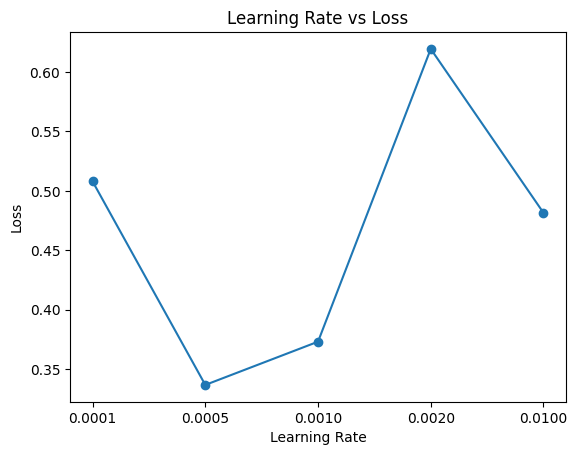

In [ ]:
# finding optimal learning rate by plotting LR vs loss
plt.plot(range(len(lrs)), history.history['loss'], marker='o')
plt.xticks(ticks=range(len(lrs)), labels=[f"{lr:.4f}" for lr in lrs])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.show()

# Hyperparameter Tuning: Batch Size

Tuning batch size is also important when trying to optimize a model.

If the batch size is too small, the model's learning may become unstable, as small batches will usually have more variability and thus noise, making it harder for the model to converge smoothly. If the batch size is too large, the model may overfit to the training data and fail to generalize well on unseen data.

We iterate over some different batch sizes below and compare our results.

In [ ]:
# tune batch size with optimized learning rate

batch_sizes = [32, 64, 128]

scores = {}

# iterate over batch sizes to find the optimal batch size
for batch_size in batch_sizes:

  # use optimal LR
  lstm = get_lstm_model(lr=0.0005)
  lstm.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    )

  y_pred = lstm.predict(X_test)
  y_pred = (y_pred > 0.5).astype(int)
  scores[batch_size] = accuracy_score(y_test, y_pred)
  print(scores)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 183s 104ms/step - accuracy: 0.6947 - loss: 0.5556 - val_accuracy: 0.8629 - val_loss: 0.3521
Epoch 2/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 123s 88ms/step - accuracy: 0.8734 - loss: 0.3221 - val_accuracy: 0.8774 - val_loss: 0.3077
Epoch 3/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 143s 89ms/step - accuracy: 0.8498 - loss: 0.3514 - val_accuracy: 0.8867 - val_loss: 0.3059
Epoch 4/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 89ms/step - accuracy: 0.9172 - loss: 0.2188 - val_accuracy: 0.8956 - val_loss: 0.2671
Epoch 5/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 109s 88ms/step - accuracy: 0.9374 - loss: 0.1728 - val_accuracy: 0.9001 - val_loss: 0.2642
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step
{32: 0.9000705858626601}
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


620/620 ━━━━━━━━━━━━━━━━━━━━ 74s 113ms/step - accuracy: 0.6875 - loss: 0.5688 - val_accuracy: 0.8427 - val_loss: 0.4000
Epoch 2/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.8346 - loss: 0.3989 - val_accuracy: 0.8821 - val_loss: 0.2907
Epoch 3/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 69s 112ms/step - accuracy: 0.8744 - loss: 0.3127 - val_accuracy: 0.8687 - val_loss: 0.3272
Epoch 4/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 82s 112ms/step - accuracy: 0.8981 - loss: 0.2606 - val_accuracy: 0.8822 - val_loss: 0.2861
Epoch 5/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 87s 120ms/step - accuracy: 0.9158 - loss: 0.2240 - val_accuracy: 0.8912 - val_loss: 0.2753
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step
{32: 0.9000705858626601, 64: 0.8911969345568216}
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 56s 168ms/step - accuracy: 0.6526 - loss: 0.6062 - val_accuracy: 0.8020 - val_loss: 0.4835
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.7900 - loss: 0.4667 - val_accuracy: 0.8693 - val_loss: 0.3229
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 82s 167ms/step - accuracy: 0.8852 - loss: 0.2880 - val_accuracy: 0.8866 - val_loss: 0.2854
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.9166 - loss: 0.2248 - val_accuracy: 0.8939 - val_loss: 0.2778
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.9296 - loss: 0.1897 - val_accuracy: 0.8955 - val_loss: 0.2635
310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step
{32: 0.9000705858626601, 64: 0.8911969345568216, 128: 0.8955329232630836}


# Hyperparameter Tuning: Plotting Batch Size vs Accuracy

Our testing shows that our smallest batch size (32), was actually our best.  This may be because the smaller batch size is adding an appropriate amount of variability and noise and preventing overfitting that may occur with larger batch sizes.

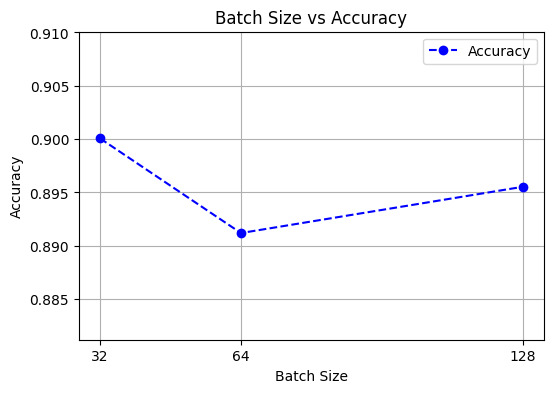

In [ ]:

# smaller batch size performs best
batch_sizes = list(scores.keys())
accuracies = list(scores.values())

# plot the batch size vs accuracy
plt.figure(figsize=(6,4))
plt.plot(batch_sizes, accuracies, marker='o', linestyle='--', color='b', label="Accuracy")

plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Batch Size vs Accuracy")
plt.xticks(batch_sizes)
plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01)
plt.grid(True)
plt.legend()

plt.show()


# Final Results and Conclusion

In the end, we have achieved about a 90% accuracy rating with our tuned LSTM model.  This is a satisfactory rating for our purposes, given that random guessing would give us about a 50% accuracy rating.

We could expect these results given our primary comparison was between an LSTM model and our hybrid CNN/GRU model.  LSTM models are specifically designed to process sequential text data like movie reviews, and excel at extracting meaning from longer sequences due to their memory, especially when Bidirectional LSTM is used (as we did in our model).  

In hindsight, I believe we could have perhaps tried to tune our secondary model (the hybrid CNN/GRU) further, as the initial results were very close to our LSTM results.  It's possible that we could have exceeded our tuned LSTM results if we had taken more time to play around with the Hybrid model.

In terms of something that didn't work, we can see that our tuned model is very similar in accuracy to our original LSTM model.  This is possibly because the hyperparameters we tested were too close to the original values, and that we should have tuned over a larger range.  It's also possible that our assessment of the optimal learning rate was wrong, which would have affected our ability to tune.

For future improvements, I think further tuning of the LSTM model architecture would yield good results.  Adding more LSTM layers could easily improve performance (at the cost of speed, of course).  We could also try adding more (or less) neurons per LSTM layer.  

I think using GloVe word embeddings would also probably improve performance, as currently we use the Keras Embedding layer to develop our embeddings concurrently with the model.  Given that GloVe is pre-trained on a larger dataset, I imagine it would boost our performance.

# References

Npathi, L. (2021). *IMDB dataset of 50K movie reviews* [Data set]. Kaggle. https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

# Github

https://github.com/unit4216/deep-learning-final/blob/main/Deep_Learning_Final.ipynb
